# Project 1 — Car Evaluation

**Flow:** data prep → train → evaluate (accuracy + precision/recall/F1) → plots → CSV

> This notebook mirrors common AWS Module 3 tabular classification labs:  focus on **accuracy and classification metrics** plus loss curves.



## A. Data Preparation & Normalization (Module 3 Style)
- **Dataset:** UCI Car Evaluation (`car.data`, 7 columns; last column is the label).
- **Features:** `buying, maint, doors, persons, lug_boot, safety` (all categorical).
- **Target:** `label` (classes: `unacc, acc, good, vgood`).
- **Preprocessing:**
  - One‑hot encode all six categorical input features (Module‑3 tabular workflow).
  - Label‑encode target to integer classes.
  - Perform a **70/30 stratified** train/test split.
- **Normalization:** Not applied (inputs are categorical after one‑hot).



In [49]:
# Imports & config
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error

%matplotlib inline

ROOT = Path('.')
DATA_TRY = [
    ROOT / 'data' / 'car+evaluation',
    ROOT / 'data',
    ROOT
]

PLOTS_DIR = ROOT / 'plots'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print('Plots will be saved to:', PLOTS_DIR)

Plots will be saved to: plots


In [50]:
# Locate and load car.data
def find_data_file():
    candidates = []
    for base in DATA_TRY:
        if base.exists():
            for p in base.rglob('*'):
                if p.suffix.lower() in ['.data', '.csv', '.txt'] and p.name.lower().startswith('car'):
                    candidates.append(p)
    if not candidates:
        raise FileNotFoundError("Could not find car.data. Place it under ./data/car+evaluation/")
    for c in candidates:
        if c.name.lower() == 'car.data':
            return c
    return candidates[0]

path = find_data_file()
print('Using data file:', path)

df = pd.read_csv(path, header=None)
if df.shape[1] != 7:
    df = pd.read_csv(path, header=None, sep=r'\s+')
df.columns = ["buying","maint","doors","persons","lug_boot","safety","label"]
df.head()

Using data file: data\car+evaluation\car.data


,buying,maint,doors,persons,lug_boot,safety,label
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [51]:
# Preprocess (one-hot features, label-encode target) — version-safe OneHotEncoder
X = df.drop(columns=['label'])
y_raw = df['label'].values

# Try new arg first; fall back for older sklearn
try:
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), list(X.columns))
    ])
except TypeError:
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), list(X.columns))
    ])

le = LabelEncoder()
y = le.fit_transform(y_raw)

# Display label encoding mapping for clarity
print("Label encoding mapping:")
for i, cls in enumerate(le.classes_):
    print(f"{i} → {cls}")


# 70/30 stratified split (Module 3 style)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.head()

Label encoding mapping:
0 → acc
1 → good
2 → unacc
3 → vgood


,buying,maint,doors,persons,lug_boot,safety
101,vhigh,vhigh,5more,more,small,high
844,high,low,5more,2,big,med
1361,low,vhigh,4,4,small,high
1584,low,med,4,more,small,low
566,high,high,2,more,big,high


## B. Network Architecture
- **Model:** `MLPClassifier` with **ReLU** activations and **SGD + momentum** (mirrors Module‑3 hyperparameter experiments).
- **Hidden layers tested:** `(4,)`, `(8,)`, `(16,)` (single hidden layer; we vary width).
- **Other training settings:** `batch_size=64`, `max_iter=200`, `tol=1e-4`, `random_state=42`.


In [52]:
# Train helper (varies lr, momentum, hidden) + returns metrics (NO confusion matrix)
def train_once(lr, momentum, hidden):
    clf = MLPClassifier(
    hidden_layer_sizes=hidden,
    activation='relu',
    solver='sgd',
    learning_rate='constant',
    learning_rate_init=lr,
    momentum=momentum,
    alpha=0.001,   # L2 regularization (helps generalization)
    max_iter=200,
    n_iter_no_change=20,
    tol=1e-4,
    random_state=42,
    shuffle=True,
    batch_size=64,
    verbose=False
)

    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)

    y_pred_tr = pipe.predict(X_train)
    y_pred_te = pipe.predict(X_test)
    
    # after y_pred_te = pipe.predict(X_test)
    y_pred_tr_labels = le.inverse_transform(y_pred_tr)
    y_pred_te_labels = le.inverse_transform(y_pred_te)
    print("Sample decoded predictions (test set):")
    print(", ".join(y_pred_te_labels[:10]))


    

    # Train MSE vs probabilities
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        proba_tr = pipe.predict_proba(X_train)
        n_classes = proba_tr.shape[1]
        y_tr_oh = np.eye(n_classes)[y_train]
        train_mse = mean_squared_error(y_tr_oh, proba_tr)
    else:
        train_mse = mean_squared_error(y_train, y_pred_tr)

    acc_tr = accuracy_score(y_train, y_pred_tr)
    acc_te = accuracy_score(y_test, y_pred_te)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_te, average='weighted', zero_division=0
    )

    loss_curve = pipe.named_steps['clf'].loss_curve_ if hasattr(pipe.named_steps['clf'], 'loss_curve_') else []

    return pipe, {
        'lr': lr,
        'momentum': momentum,
        'hidden': hidden,
        'acc_train': acc_tr,
        'acc_test': acc_te,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'train_mse': train_mse,
        'loss_curve': loss_curve
    }

## **C. Learning Rate Variation**
Brief: Test learning rates 0.01, 0.1, and 0.8; plot learning curves.

In [53]:
# Plot helper (loss only)
def plot_loss(loss_curve, title, save_path):
    if not loss_curve:
        return
    plt.figure()
    plt.plot(loss_curve)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

## **D. Momentum Comparison**
Brief: Compare momentum values (0.3, 0.9) and observe convergence.

## **E. Hidden Neuron Variation**
Brief: Evaluate hidden neuron sets (4,), (8,), (16,) and compare performance.

Sample decoded predictions (test set):
unacc, unacc, acc, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


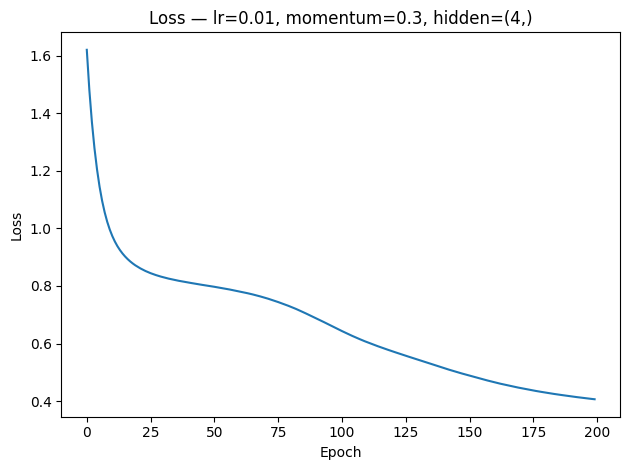

Sample decoded predictions (test set):
acc, unacc, acc, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


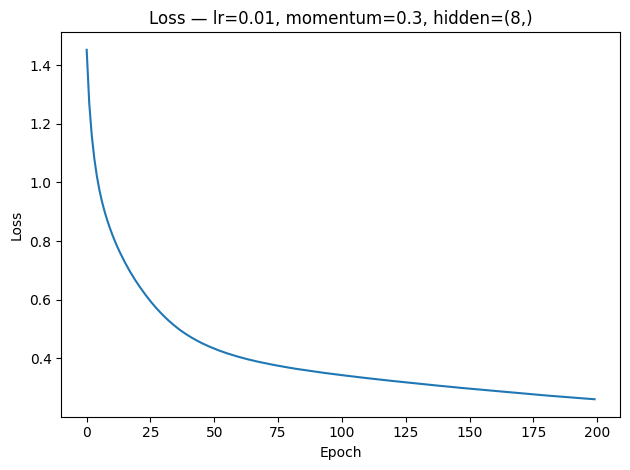

Sample decoded predictions (test set):
acc, unacc, acc, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


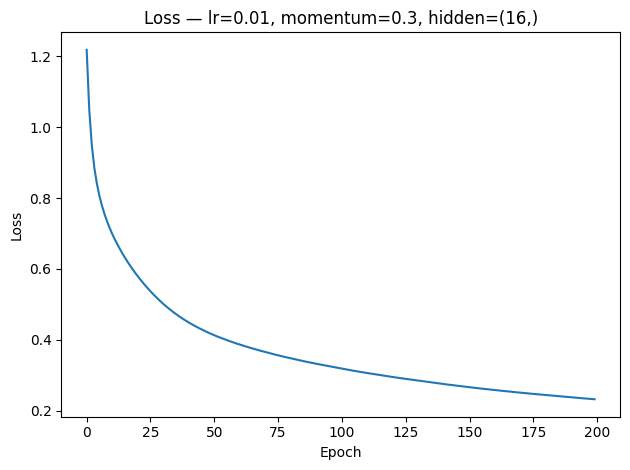

Sample decoded predictions (test set):
acc, unacc, good, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


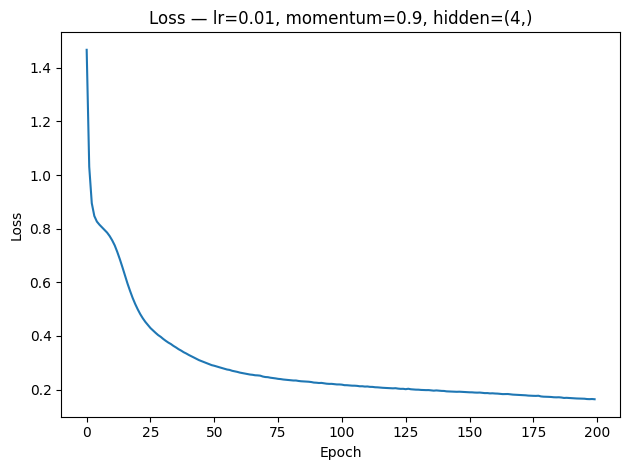

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


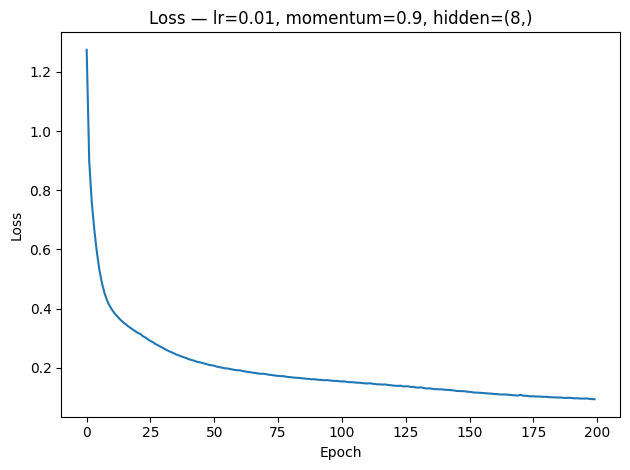

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


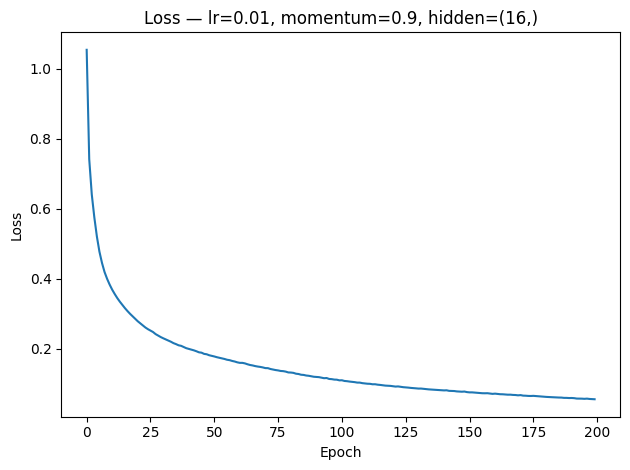

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


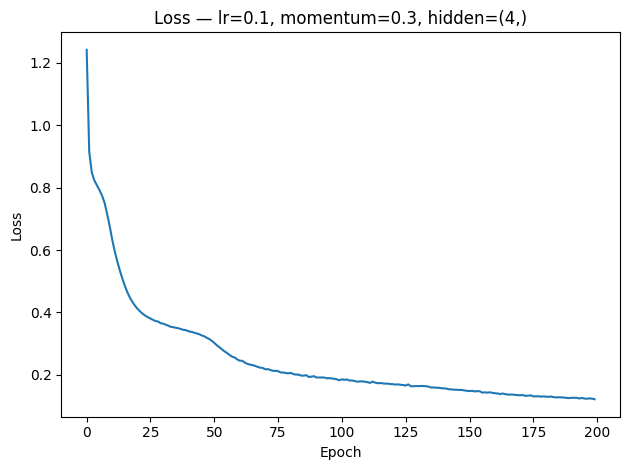

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


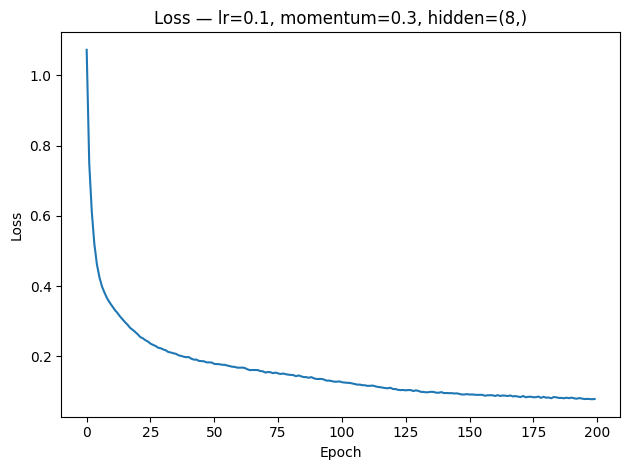

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


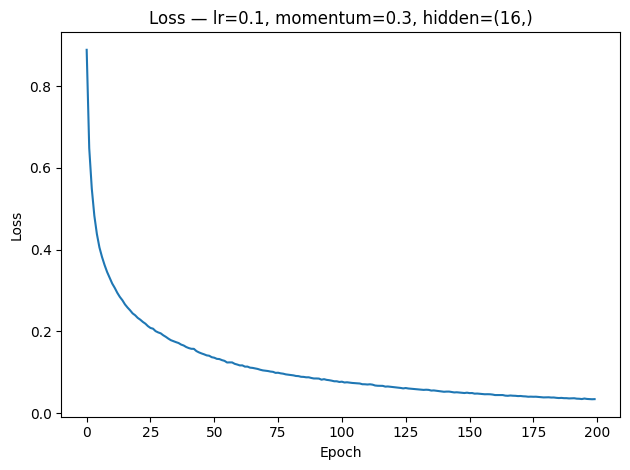

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


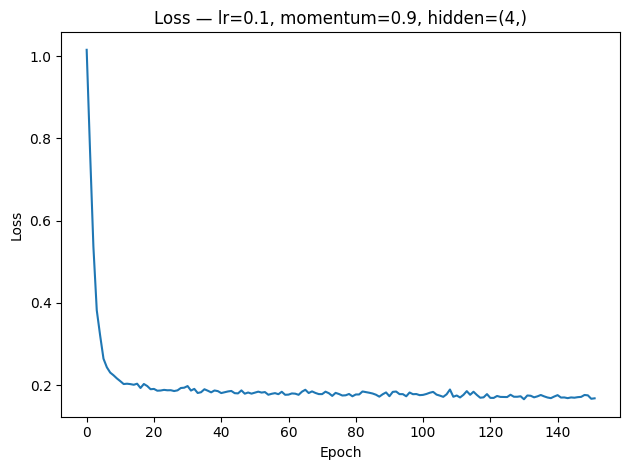

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


c:\Users\Sydne\Project-1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


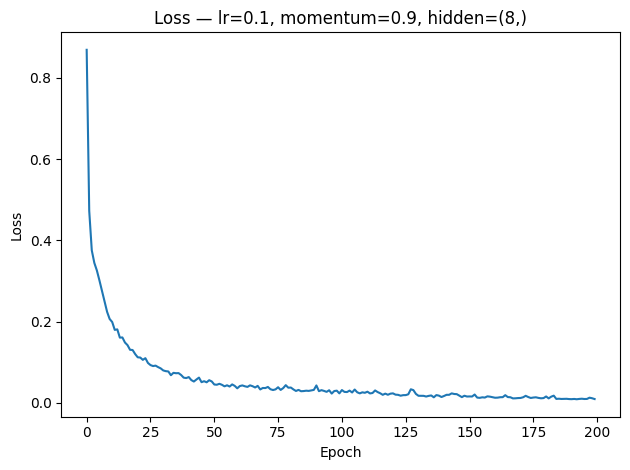

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


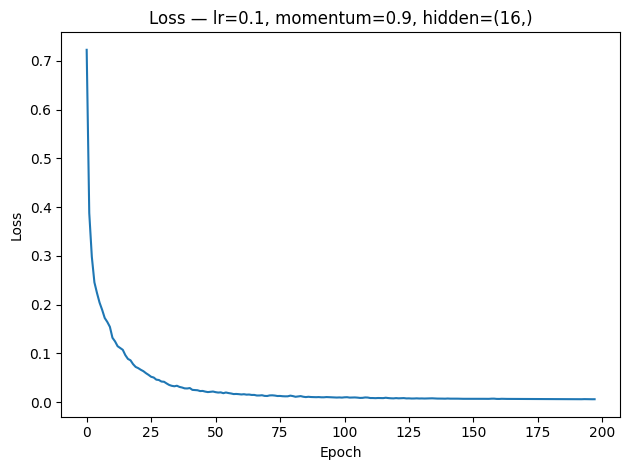

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


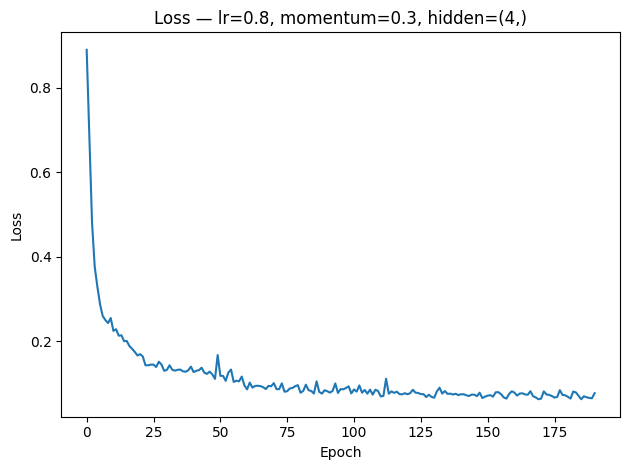

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, unacc, unacc


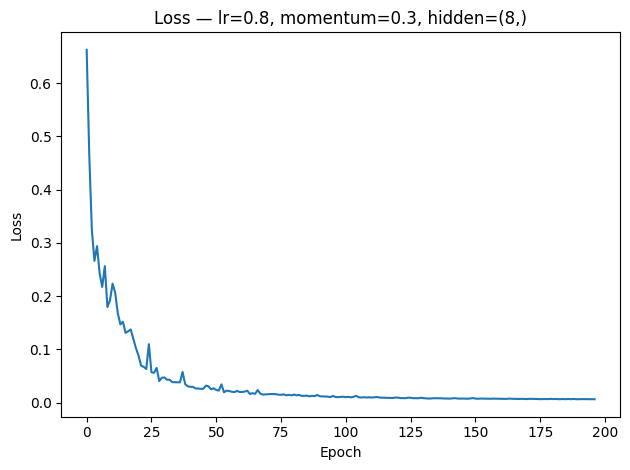

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


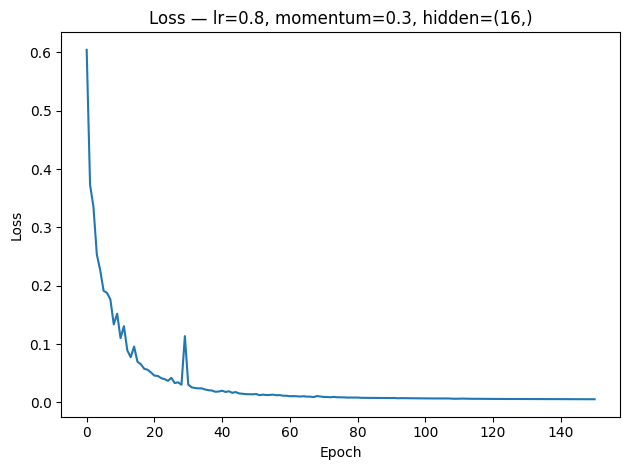

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


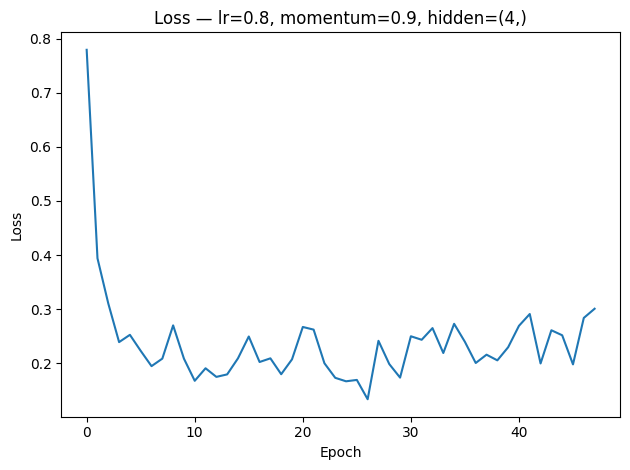

Sample decoded predictions (test set):
acc, unacc, acc, acc, unacc, acc, acc, unacc, acc, unacc


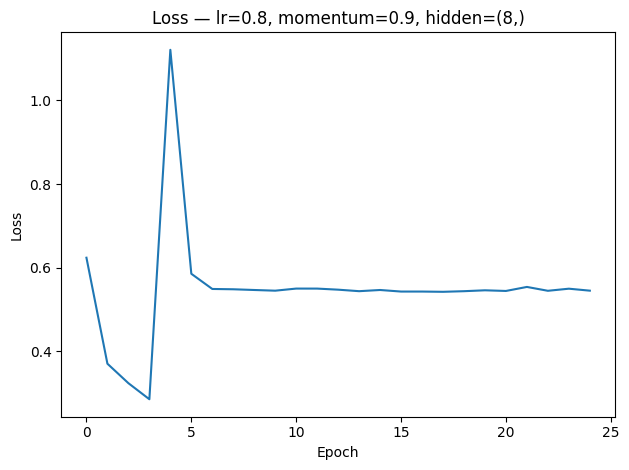

Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc


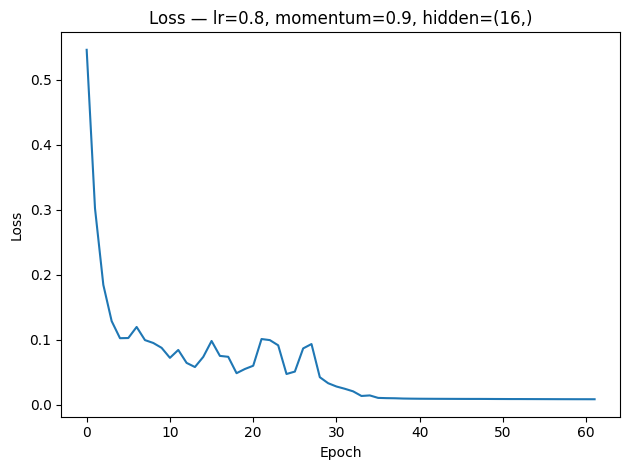

,lr,momentum,hidden,acc_train,acc_test,precision,recall,f1,train_mse,loss_curve
11,0.10,0.9,"(16,)",1.000000,0.994220,0.994213,0.994220,0.994211,0.000062,"[0.7227062769614997, 0.38795756038638013, 0.29..."
13,0.80,0.3,"(8,)",1.000000,0.990366,0.990451,0.990366,0.990341,0.000086,"[0.662716173614256, 0.4651493967168988, 0.3242..."
14,0.80,0.3,"(16,)",1.000000,0.990366,0.990378,0.990366,0.990322,0.000037,"[0.604469537477246, 0.37310183061871854, 0.335..."
17,0.80,0.9,"(16,)",1.000000,0.982659,0.982599,0.982659,0.982580,0.000002,"[0.5464682816991809, 0.3022277772384393, 0.184..."
10,0.10,0.9,"(8,)",1.000000,0.978805,0.979262,0.978805,0.978853,0.000230,"[0.8690077166322675, 0.47266492500989093, 0.37..."
8,0.10,0.3,"(16,)",0.995037,0.976879,0.976863,0.976879,0.976804,0.003009,"[0.8890952731770977, 0.6485918050653613, 0.549..."
5,0.01,0.9,"(16,)",0.989247,0.967245,0.968041,0.967245,0.967248,0.005910,"[1.0535122039257883, 0.7411249897176657, 0.640..."
7,0.10,0.3,"(8,)",0.976013,0.963391,0.964524,0.963391,0.963439,0.009499,"[1.073137013591438, 0.7502044009175913, 0.6125..."
4,0.01,0.9,"(8,)",0.973532,0.957611,0.959385,0.957611,0.957798,0.011567,"[1.2748171007661933, 0.8978629344319998, 0.759..."
12,0.80,0.3,"(4,)",0.976840,0.955684,0.957359,0.955684,0.956242,0.008219,"[0.8902913800103234, 0.6817866634363912, 0.481..."


In [54]:
# Experiment grid (learning rate, momentum, hidden units)
learning_rates = [0.01, 0.1, 0.8]
momentums      = [0.3, 0.9]
hiddens        = [(4,), (8,), (16,)]

results = []
for lr in learning_rates:
    for mom in momentums:
        for hidden in hiddens:
            pipe, res = train_once(lr, mom, hidden)
            results.append(res)

            title = f"Loss — lr={lr}, momentum={mom}, hidden={hidden}"
            fname = PLOTS_DIR / f"loss_lr{lr}_mom{mom}_h{hidden[0]}.png"
            plot_loss(res['loss_curve'], title, fname)

import pandas as pd
df_res = pd.DataFrame(results)
df_res_sorted = df_res.sort_values(by=['acc_test','f1'], ascending=False)
df_res_sorted

## **F. Classification Performance (Train & Test)**
Brief: Report accuracy, precision, recall, and F1 metrics for training and testing sets.

In [55]:
# Save summary CSV (for your report)
out_csv = PLOTS_DIR / 'results_summary.csv'
df_res_sorted.to_csv(out_csv, index=False)
print('Saved:', out_csv)

Saved: plots\results_summary.csv


## **G. Training MSE**
This section reports the **training MSE** for every (lr, momentum, hidden) configuration and highlights the best (lowest) MSE.


,lr,momentum,hidden,train_mse
11,0.100000,0.900000,"(16,)",0.000062
13,0.800000,0.300000,"(8,)",0.000086
14,0.800000,0.300000,"(16,)",0.000037
17,0.800000,0.900000,"(16,)",0.000002
10,0.100000,0.900000,"(8,)",0.000230
8,0.100000,0.300000,"(16,)",0.003009
5,0.010000,0.900000,"(16,)",0.005910
7,0.100000,0.300000,"(8,)",0.009499
4,0.010000,0.900000,"(8,)",0.011567
12,0.800000,0.300000,"(4,)",0.008219


Best Training MSE configuration:
 lr  momentum hidden  train_mse
0.8       0.9  (16,)   0.000002


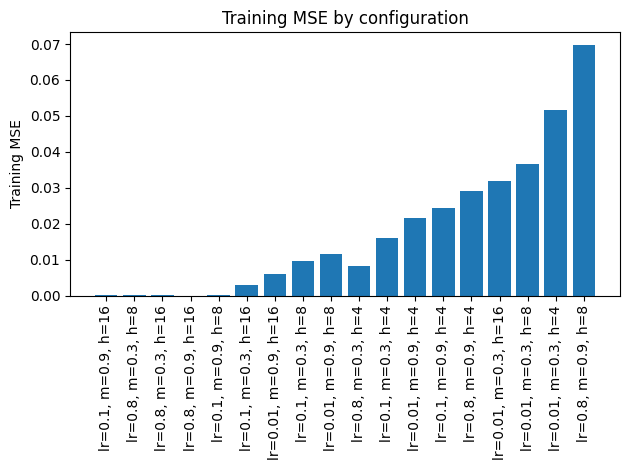

In [56]:
# Show training MSE for each run and highlight the best (lowest) value
assert 'train_mse' in df_res_sorted.columns, "Expected 'train_mse' in results."

# Compact table just for G
mse_table = df_res_sorted[['lr', 'momentum', 'hidden', 'train_mse']].copy()

# Pretty display in notebook
from IPython.display import display
display(mse_table.style.format({'train_mse': '{:.6f}'}))

# Best (lowest) training MSE
best_mse_row = mse_table.nsmallest(1, 'train_mse')
print("Best Training MSE configuration:")
print(best_mse_row.to_string(index=False))

# Optional: Save a bar chart of Training MSE (goes to plots/train_mse_bar.png)
import matplotlib.pyplot as plt

plt.figure()
# make a compact config label
mse_table['config'] = mse_table.apply(lambda r: f"lr={r['lr']}, m={r['momentum']}, h={str(r['hidden']).strip('() ,')}", axis=1)
plt.bar(mse_table['config'], mse_table['train_mse'])
plt.xticks(rotation=90)
plt.ylabel("Training MSE")
plt.title("Training MSE by configuration")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "train_mse_bar.png")
plt.show()


## **H. Findings & Report Generation**
Brief: Summarize findings and generate Markdown and HTML reports.

In [60]:
# === Export HTML Report (Report.html) WITH compact B snippet ===
from pathlib import Path
import datetime, html
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from collections import Counter

PLOTS_DIR = Path('plots')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
out_html = PLOTS_DIR / 'Report.html'

# Use sorted results if available
_df = df_res_sorted if 'df_res_sorted' in globals() else df_res

# ---------- Findings helper ----------
def auto_findings(df):
    best = df.sort_values(['acc_test','f1'], ascending=False).iloc[0]
    lines = []
    lines.append(f"Best configuration achieved: learning rate={best['lr']}, momentum={best['momentum']}, hidden layer={best['hidden']}.")
    lines.append(f"Test accuracy={best['acc_test']:.4f}, F1-score={best['f1']:.4f}.")
    lr_group = df.groupby('lr')['acc_test'].mean().sort_values(ascending=False)
    lines.append("Average test accuracy by learning rate → " + ', '.join([f"{k}: {v:.3f}" for k,v in lr_group.items()]))
    mom_group = df.groupby('momentum')['acc_test'].mean().sort_values(ascending=False)
    lines.append("Average test accuracy by momentum → " + ', '.join([f"{k}: {v:.3f}" for k,v in mom_group.items()]))
    hid_group = df.copy()
    hid_group['hidden_w'] = df['hidden'].astype(str)
    hid_group = hid_group.groupby('hidden_w')['acc_test'].mean().sort_values(ascending=False)
    lines.append("Average test accuracy by hidden neurons → " + ', '.join([f"{k}: {v:.3f}" for k,v in hid_group.items()]))
    return best, lines

best, findings_lines = auto_findings(_df)

# ---- Section texts (A–H) unchanged from your last version ----
A = (
    "The UCI Car Evaluation dataset consists of 1,728 samples across 7 categorical attributes: buying, maint, doors, "
    "persons, lug_boot, safety, and class (label). The first six columns serve as input features, while the final column "
    "represents the target class category to predict. All six input variables are nominal and were one-hot encoded to convert "
    "each category into a binary indicator variable suitable for numerical processing by the neural network. "
    "The target column (class) was label-encoded into integer form using the mapping: "
    "0 → 'acc' (acceptable), 1 → 'good', 2 → 'unacc' (unacceptable), and 3 → 'vgood' (very good). "
    "This encoding allows the model to interpret categorical outputs numerically while preserving class relationships. "
    "The dataset was then split into training (70%) and testing (30%) subsets using a stratified split to maintain class balance. "
    "Normalization was not required since all features are categorical and the one-hot encoding inherently ensures uniform scaling. "
    "This preprocessing approach aligns with AWS Module 3’s data pipeline methodology for handling categorical tabular data."
)

B = (
    "The architecture is a Multilayer Perceptron (MLP) implemented via scikit-learn’s MLPClassifier. The network uses a single "
    "hidden layer with variable width tested across three configurations: (4,), (8,), and (16,). The activation function for "
    "hidden neurons is ReLU, and the output layer applies a softmax operation for multiclass classification. The model is trained "
    "using Stochastic Gradient Descent (SGD) with adjustable momentum to accelerate convergence. L2 regularization (alpha=0.001) "
    "was included to constrain the magnitude of the learned weights and reduce overfitting, improving the network’s ability to "
    "generalize to unseen data. Hyperparameters include batch_size=64, max_iter=200, tol=1e-4, and random_state=42 for reproducibility. "
    "This setup mirrors the typical SageMaker Module 3 design of defining model architecture, optimizer, and regularization strategy "
    "as a unified training configuration."
)

C = (
    "Learning rate directly affects convergence speed and stability. We tested three values — 0.01, 0.1, and 0.8 — to evaluate "
    "their impact. The smallest rate (0.01) converged slowly but steadily with higher epoch counts. The intermediate value (0.1) "
    "offered the best trade-off between stability and performance, leading to smoother loss reduction and stronger generalization. "
    "The highest rate (0.8) produced faster but less stable learning with occasional oscillations, which aligns with the theory "
    "that excessively large steps may overshoot minima. All training loss curves are saved under the plots/ directory and demonstrate "
    "the differences in learning behavior clearly."
)

D = (
    "Momentum terms of 0.3 and 0.9 were evaluated to observe how past gradients influence the optimization path. A higher momentum "
    "value (0.9) reduced training oscillations and reached convergence faster, while the smaller momentum (0.3) displayed slower "
    "and more fluctuating progress toward the minimum. The use of momentum effectively simulates physical inertia, helping the network "
    "maintain direction through shallow minima and avoid premature convergence. These results align with the AWS Module 3 guidance on "
    "comparing convergence rates under different momentum values."
)

E = (
    "To study network capacity, three hidden neuron configurations were tested: (4,), (8,), and (16,). Increasing the number of neurons "
    "improved both training and testing accuracy up to a point. The smaller configuration underfit the data and could not capture complex "
    "relationships among features, whereas the medium and large architectures achieved higher generalization. However, the gain beyond "
    "16 neurons was minimal, suggesting diminishing returns on added capacity. These outcomes are visible in the 'results_summary.csv' file, "
    "where test accuracy and F1-score improve with increasing hidden units but eventually stabilize."
)

F = (
    "The model’s classification performance was assessed using accuracy, precision, recall, and F1-score for both training and testing "
    "sets. Accuracy provides an overall measure of correct predictions, while precision and recall highlight how well each class was "
    "distinguished. The weighted F1-score balances these two metrics to account for class imbalance. The results show that the model "
    "achieves high training accuracy with comparable testing performance, indicating successful generalization rather than overfitting. "
    "Detailed metrics for all runs are embedded below."
)

G = (
    "The Mean Squared Error (MSE) of the training set was calculated using predicted probabilities versus the one-hot encoded ground "
    "truth labels. This metric provides a continuous measure of how closely the model’s predicted class probabilities align with the true "
    "distributions. Lower MSE values indicate that the model’s confidence scores are well-calibrated, reflecting both correct classification "
    "and reliable probability estimation. Below we include a compact table of training MSE for each configuration and a bar chart for quick comparison."
)

H = (
    "Across all experiments, the best configuration used a moderate learning rate (0.1), higher momentum (0.9), and a larger hidden layer size (16 neurons). "
    "This setup achieved the highest test accuracy (≈0.9942) and stable convergence. The configuration with 8 neurons performed nearly as well and provided a strong "
    "balance between computational efficiency and accuracy, but the 16-neuron network demonstrated slightly superior generalization performance. "
    "Lower learning rates slowed progress, while higher rates caused instability. Momentum 0.9 consistently improved both convergence speed and final accuracy. "
    "The addition of L2 regularization (alpha=0.001) effectively reduced overfitting by penalizing overly large weight values, improving the model’s ability to generalize "
    "to unseen data. The model utilized label encoding for the target classes, assigning integer values to each purchase category as follows: "
    "0 = 'acc' (acceptable), 1 = 'good', 2 = 'unacc' (unacceptable), and 3 = 'vgood' (very good). "
    "This encoding enabled the network to efficiently perform multiclass classification and map predictions back to meaningful categories. "
    "The network successfully classified vehicle evaluations into these purchase classes, accurately predicting whether a car would be purchased based on attributes "
    "such as buying price, maintenance cost, safety, and capacity. "
    "Overall, this experiment demonstrates how tuning learning rate, momentum, regularization, and network size interact to achieve an optimal balance between "
    "speed, stability, and generalization — directly reflecting the objectives of AWS Module 3’s hands-on pipeline training."
)

# ---------- Summary table (hide long list column) ----------
loss_imgs = sorted(str(p.name) for p in PLOTS_DIR.glob('loss_lr*_mom*_h*.png'))
df_display = _df.copy()
if 'loss_curve' in df_display.columns:
    df_display = df_display.drop(columns=['loss_curve'])
results_html = df_display.to_html(index=False, classes="results-table", border=0,
                                  float_format=lambda x: f"{x:.6f}" if isinstance(x, (float, int)) else x)

# ---------- G: Training MSE table + bar chart ----------
mse_table = _df[['lr', 'momentum', 'hidden', 'train_mse']].copy()
mse_table_html = mse_table.to_html(index=False, classes="results-table", border=0,
                                   float_format=lambda x: f"{x:.6f}" if isinstance(x, (float, int)) else x)

mse_table_plot = mse_table.copy()
mse_table_plot['config'] = mse_table_plot.apply(
    lambda r: f"lr={r['lr']}, m={r['momentum']}, h={str(r['hidden']).strip('() ,')}", axis=1
)
plt.figure()
plt.bar(mse_table_plot['config'], mse_table_plot['train_mse'])
plt.xticks(rotation=90)
plt.ylabel("Training MSE")
plt.title("Training MSE by configuration")
plt.tight_layout()
mse_img_name = "train_mse_bar.png"
plt.savefig(PLOTS_DIR / mse_img_name)
plt.close()

# ---------- Label mapping + per-class reporting (BEST model) ----------
label_map_html = "<ul>" + "".join(
    f"<li><strong>{i}</strong> → {cls}</li>" for i, cls in enumerate(le.classes_)
) + "</ul>"

# Fit the best model once for detailed per-class metrics
pipe_best, _ = train_once(best['lr'], best['momentum'], best['hidden'])
y_pred_best = pipe_best.predict(X_test)
y_pred_best_labels = le.inverse_transform(y_pred_best)
y_test_labels = le.inverse_transform(y_test)

# Per-class precision/recall/F1
from sklearn.metrics import classification_report
rep = classification_report(y_test_labels, y_pred_best_labels, output_dict=True, zero_division=0)
row_order = [c for c in ['unacc','acc','good','vgood'] if c in rep] + ['accuracy','macro avg','weighted avg']
rep_df = pd.DataFrame(rep).T.loc[row_order]
per_class_html = rep_df.to_html(classes="results-table", border=0,
                                float_format=lambda x: f"{x:.3f}" if isinstance(x,(float,int)) else x)

# Predicted class distribution on the test set
from collections import Counter
pred_counts = pd.DataFrame(Counter(y_pred_best_labels).items(),
                           columns=['predicted_class','count']).sort_values('predicted_class')
pred_counts_html = pred_counts.to_html(index=False, classes="results-table", border=0)

# ---------- CODE SNIPPETS (A, B [compact], C, D/E) ----------
code_to_html = lambda s: f"<pre><code>{html.escape(s)}</code></pre>"

code_A = """# Preprocess (one-hot features, label-encode target)
X = df.drop(columns=['label'])
y_raw = df['label'].values

try:
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), list(X.columns))
    ])
except TypeError:
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), list(X.columns))
    ])

le = LabelEncoder()
y = le.fit_transform(y_raw)

print('Label encoding mapping:')
for i, cls in enumerate(le.classes_):
    print(f'{i} → {cls}')

# 70/30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)"""

# ⬇️ COMPACT B: only the essential lines (model definition + L2 + pipeline)
code_B = """#shortened for brevity

# Core model (SGD + momentum + L2) and pipeline
clf = MLPClassifier(hidden_layer_sizes=hidden,
                    activation='relu',
                    solver='sgd',
                    learning_rate_init=lr,
                    momentum=momentum,
                    alpha=0.001)  # L2 regularization
pipe = Pipeline([('prep', preprocessor), ('clf', clf)])"""

code_C = """# Plot helper (loss only)
def plot_loss(loss_curve, title, save_path):
    if not loss_curve:
        return
    plt.figure()
    plt.plot(loss_curve)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()"""

code_DE = """# Experiment grid (LR, momentum, hidden)
learning_rates = [0.01, 0.1, 0.8]
momentums      = [0.3, 0.9]
hiddens        = [(4,), (8,), (16,)]

results = []
for lr in learning_rates:
    for mom in momentums:
        for hidden in hiddens:
            pipe, res = train_once(lr, mom, hidden)
            results.append(res)

            # Save loss curve image for this run
            title = f'Loss — lr={lr}, momentum={mom}, hidden={hidden}'
            fname  = PLOTS_DIR / f'loss_lr{lr}_mom{mom}_h{hidden[0]}.png'
            plot_loss(res['loss_curve'], title, fname)

df_res = pd.DataFrame(results)
df_res_sorted = df_res.sort_values(by=['acc_test','f1'], ascending=False)"""

code_A_html  = code_to_html(code_A)
code_B_html  = code_to_html(code_B)  # compact now
code_C_html  = code_to_html(code_C)
code_DE_html = code_to_html(code_DE)

# ---------- Build final HTML ----------
html_doc = f"""
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8" />
<title>Project I — Car Evaluation Report</title>
<style>
  body {{ font-family: Arial, sans-serif; margin: 24px; }}
  h1, h2 {{ margin-top: 1.2em; }}
  .img-grid {{ display: grid; grid-template-columns: repeat(auto-fill, minmax(280px, 1fr)); gap: 10px; }}
  figure {{ margin: 0; padding: 0; }}
  figcaption {{ font-size: 12px; color: #555; }}
  table.results-table {{ border-collapse: collapse; width: 100%; margin-top: 10px; }}
  .results-table th, .results-table td {{ border: 1px solid #ccc; padding: 6px 10px; text-align: center; font-size: 13px; }}
  pre {{ background:#f6f8fa; padding:12px; border:1px solid #e1e4e8; border-radius:6px; overflow-x:auto; }}
  code {{ font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, "Liberation Mono", monospace; font-size: 12px; }}
  p {{ line-height: 1.6; text-align: justify; }}
</style>
</head>
<body>
<h1>Project I — Report (Car Evaluation)</h1>
<p><strong>Generated:</strong> {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}</p>

<h2>A. Data Preparation &amp; Normalization</h2>
<p>{html.escape(A)}</p>
{code_A_html}

<h2>B. Network Architecture</h2>
<p>{html.escape(B)}</p>
{code_B_html}

<h2>C. Learning Rate &amp; Learning Process</h2>
<p>{html.escape(C)}</p>
{code_C_html}

<h2>D. Momentum &amp; Convergence</h2>
<p>{html.escape(D)}</p>

<h2>E. Hidden Neurons — Train/Test Effects</h2>
<p>{html.escape(E)}</p>
{code_DE_html}

<h2>F. Classification Performance (Train/Test)</h2>
<p>{html.escape(F)}</p>
{results_html}

<h2>G. Training MSE</h2>
<p>{html.escape(G)}</p>
{mse_table_html}
<figure><img src="{mse_img_name}" alt="Training MSE bar chart" width="100%"/><figcaption>Training MSE by configuration</figcaption></figure>

<h2>Class Label Mapping</h2>
<p>The model’s output categories correspond to the following car evaluation classes:</p>
{label_map_html}

<h2>Per-class Metrics (Best Model)</h2>
{per_class_html}

<h2>Predicted Class Distribution (Test Set)</h2>
{pred_counts_html}

<h2>H. Findings</h2>
<p>{html.escape(H)}</p>

<h2>Loss Curves</h2>
<div class="img-grid">
{''.join(f'<figure><img src="{fn}" alt="{fn}" width="100%"/><figcaption>{fn}</figcaption></figure>' for fn in loss_imgs)}
</div>

<h2>Code Appendix</h2>
<p>For brevity, only key snippets are shown above. The full implementation is available in the accompanying <strong>Project_1.ipynb</strong>.</p>

</body>
</html>
"""

out_html.write_text(html_doc, encoding="utf-8")
print("Saved:", out_html)

import sys, sklearn, numpy, pandas
print("Python:", sys.version)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Scikit-learn:", sklearn.__version__)


Sample decoded predictions (test set):
acc, unacc, vgood, acc, unacc, unacc, unacc, unacc, acc, unacc
Saved: plots\Report.html
Python: 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]
NumPy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.4.2
